In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F

pd.set_option('display.max_columns', None)

In [3]:
supervector_df_Standard = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250428_1434\supervector.csv')
print("Supervector DataFrame :")
supervector_df_Standard.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness
0,29.226378,31.422612,300.0,0.0
1,28.979889,31.358813,301.0,0.0
2,28.755991,31.312190,302.0,0.0
3,28.546622,31.275586,303.0,0.0
4,28.348329,31.246076,304.0,0.0


In [4]:
supervector_df_Maxwell_Garnett = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250428_1444\supervector_maxwell_garnett.csv')
print("Supervector DataFrame :")
supervector_df_Maxwell_Garnett.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness,vfraction
0,29.226378,31.422612,300.0,0.0,0.01
1,28.979889,31.358813,301.0,0.0,0.01
2,28.755991,31.312190,302.0,0.0,0.01
3,28.546622,31.275586,303.0,0.0,0.01
4,28.348329,31.246076,304.0,0.0,0.01


In [5]:
supervector_df_Lorentz = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250429_2344\supervector_lorentzian.csv')
print("Supervector DataFrame :")
supervector_df_Lorentz.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness,lambda0,gamma,amplitude
0,29.226378,31.422612,300.0,0.0,438.240013,67.038748,0.251549
1,28.979889,31.358813,301.0,0.0,438.240013,67.038748,0.251549
2,28.755991,31.312190,302.0,0.0,438.240013,67.038748,0.251549
3,28.546622,31.275586,303.0,0.0,438.240013,67.038748,0.251549
4,28.348329,31.246076,304.0,0.0,438.240013,67.038748,0.251549


In [6]:
def group_and_flatten(df):
    # Déterminer les colonnes de groupement possibles
    possible_group_cols = ['vfraction', 'thickness', 'lambda0', 'gamma', 'amplitude']
    
    # Trouver les colonnes de groupement qui existent dans le dataframe
    group_cols = [col for col in possible_group_cols if col in df.columns]
    
    # Si aucune colonne de groupement n'est trouvée, on peut utiliser une colonne par défaut ou lever une exception
    if not group_cols:
        raise ValueError("Aucune colonne de groupement appropriée trouvée dans le dataframe")
    
    # Effectuer le groupby et le flatten
    grouped = df.groupby(group_cols)[['psi', 'delta']].apply(
        lambda x: x.values.flatten()
    ).reset_index()
    
    # Renommer la colonne résultante
    grouped.columns = list(group_cols) + ['psi_delta_flatten']
    
    return grouped

# Utilisation pour chaque dataset
grouped_standard = group_and_flatten(supervector_df_Standard)
grouped_maxwell = group_and_flatten(supervector_df_Maxwell_Garnett)
grouped_lorentz = group_and_flatten(supervector_df_Lorentz)


In [7]:
import numpy as np

def prepare_features_labels(grouped_df):
    """
    Prépare les matrices X (features) et y (labels) à partir d'un DataFrame groupé
    
    Args:
        grouped_df: DataFrame résultant de la fonction group_and_flatten
    
    Returns:
        X: matrice des features (valeurs de psi et delta flatten)
        y: matrice des labels (toutes les colonnes sauf 'psi_delta_flatten')
        feature_names: noms des colonnes utilisées comme labels
    """
    # Features (X) - toujours la colonne flatten
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    
    # Labels (y) - toutes les colonnes sauf 'psi_delta_flatten'
    label_cols = [col for col in grouped_df.columns if col != 'psi_delta_flatten']
    y = grouped_df[label_cols].values
    
    print(f"Dimensions des entrées (X): {X.shape}")
    print(f"Dimensions des sorties (y): {y.shape}")
    print(f"Colonnes utilisées comme labels: {label_cols}")
    
    return X, y, label_cols

In [8]:
# Pour le dataset Standard
X_std, y_std, labels_std = prepare_features_labels(grouped_standard)

# Pour Maxwell-Garnett
X_mg, y_mg, labels_mg = prepare_features_labels(grouped_maxwell)

# Pour Lorentz
X_lor, y_lor, labels_lor = prepare_features_labels(grouped_lorentz)

Dimensions des entrées (X): (61, 1002)
Dimensions des sorties (y): (61, 1)
Colonnes utilisées comme labels: ['thickness']
Dimensions des entrées (X): (1830, 1002)
Dimensions des sorties (y): (1830, 2)
Colonnes utilisées comme labels: ['vfraction', 'thickness']
Dimensions des entrées (X): (1830, 1002)
Dimensions des sorties (y): (1830, 4)
Colonnes utilisées comme labels: ['thickness', 'lambda0', 'gamma', 'amplitude']


In [9]:
def prepare_and_split_data(grouped_df, test_size=0.2, random_state=42):
    """
    Prépare les données et les divise en gardant les relations entre les variables cibles
    
    Args:
        grouped_df: DataFrame après group_and_flatten
        test_size: proportion pour le test set
        random_state: seed aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test (y conserve toutes les cibles)
        et la liste des noms des cibles
    """
    # Préparation des features et labels
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    y = grouped_df.drop(columns=['psi_delta_flatten']).values
    label_names = grouped_df.drop(columns=['psi_delta_flatten']).columns.tolist()
    
    # Split en gardant toutes les cibles ensemble
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape} (labels: {label_names})")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, label_names

In [10]:
#Pour le dataset Standard (tous les paramètres ensemble)
X_train_std, X_test_std, y_train_std, y_test_std, labels_std = prepare_and_split_data(grouped_standard)

# Pour Maxwell-Garnett (vfraction + thickness ensemble)
X_train_mg, X_test_mg, y_train_mg, y_test_mg, labels_mg = prepare_and_split_data(grouped_maxwell)

# Pour Lorentz (tous les paramètres ensemble)
X_train_lor, X_test_lor, y_train_lor, y_test_lor, labels_lor = prepare_and_split_data(grouped_lorentz)

X_train shape: (48, 1002)
X_test shape: (13, 1002)
y_train shape: (48, 1) (labels: ['thickness'])
y_test shape: (13, 1)
X_train shape: (1464, 1002)
X_test shape: (366, 1002)
y_train shape: (1464, 2) (labels: ['vfraction', 'thickness'])
y_test shape: (366, 2)
X_train shape: (1464, 1002)
X_test shape: (366, 1002)
y_train shape: (1464, 4) (labels: ['thickness', 'lambda0', 'gamma', 'amplitude'])
y_test shape: (366, 4)


In [11]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

def preprocess_and_convert(X_train, X_test, y_train, y_test):
    """
    Applique uniquement une normalisation MinMax aux features et labels.

    Args:
        X_train, X_test: Données d'entrée (features) d'entraînement et de test
        y_train, y_test: Labels (sorties) d'entraînement et de test

    Returns:
        Dictionnaire contenant les tenseurs normalisés et les scalers MinMax
    """
    # Scaler MinMax pour les features
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scaler MinMax pour les labels
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }

def inverse_transform_y(y_pred_tensor, scaler_y):
    """
    Inverse la normalisation MinMax des prédictions.

    Args:
        y_pred_tensor: Tenseur PyTorch des prédictions.
        scaler_y: Scaler MinMax utilisé pour normaliser y.

    Returns:
        Prédictions dans l'échelle d'origine (numpy array).
    """
    if scaler_y is None:
        return y_pred_tensor.numpy()
    
    y_pred_np = y_pred_tensor.detach().numpy()
    return scaler_y.inverse_transform(y_pred_np)


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class FlexibleNN(nn.Module):
    """
    Réseau neuronal flexible simplifié avec:
    - Nombre de couches configurable
    - Activation paramétrable
    - Initialisation intelligente
    - Pas de BatchNorm
    """
    def __init__(self, input_dim, output_dim, 
                 hidden_dims=[256, 256, 256],
                 activation='leaky_relu',
                 dropout_rate=0.0):
        super(FlexibleNN, self).__init__()
        
        # Configuration des couches
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Construction dynamique des couches cachées
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(self._get_activation(activation))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(dims[-1], output_dim)
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        """Initialisation adaptative des poids"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.1)
    
    def _get_activation(self, name):
        """Retourne la fonction d'activation"""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
        }.get(name.lower(), nn.LeakyReLU(0.1))
    
    def forward(self, x):
        x = self.hidden_layers(x)
        return self.output(x)

In [13]:
# Courbes de loss
def plot_losses(train_loss, test_loss, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Caourbes de Loss - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(model, X_test, y_test, scaler_y, label_names, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Conversion inverse des données normalisées
    y_test_orig = inverse_transform_y(y_test, scaler_y)  # Removed param_names argument
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)  # Removed param_names argument
    
    # Création des graphiques pour chaque paramètre
    n_params = y_test.shape[1]
    plt.figure(figsize=(15, 3*n_params))
    
    for i in range(n_params):
        plt.subplot(1, n_params, i+1)
        plt.scatter(y_test_orig[:, i], y_pred_orig[:, i], alpha=0.5)
        plt.plot([y_test_orig[:, i].min(), y_test_orig[:, i].max()], 
                 [y_test_orig[:, i].min(), y_test_orig[:, i].max()], 'r--')
        plt.xlabel('Valeur réelle')
        plt.ylabel('Valeur prédite')
        plt.title(f'{title} - {label_names[i]}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


=== Traitement du dataset Standard ===

Sans augmentation:
Epoch 20/150 - Train Loss: 0.0868, Test Loss: 0.0480
Epoch 40/150 - Train Loss: 0.0522, Test Loss: 0.0107
Epoch 60/150 - Train Loss: 0.0209, Test Loss: 0.0050
Epoch 80/150 - Train Loss: 0.0195, Test Loss: 0.0057
Epoch 100/150 - Train Loss: 0.0202, Test Loss: 0.0061
Epoch 120/150 - Train Loss: 0.0098, Test Loss: 0.0061
Epoch 140/150 - Train Loss: 0.0100, Test Loss: 0.0048


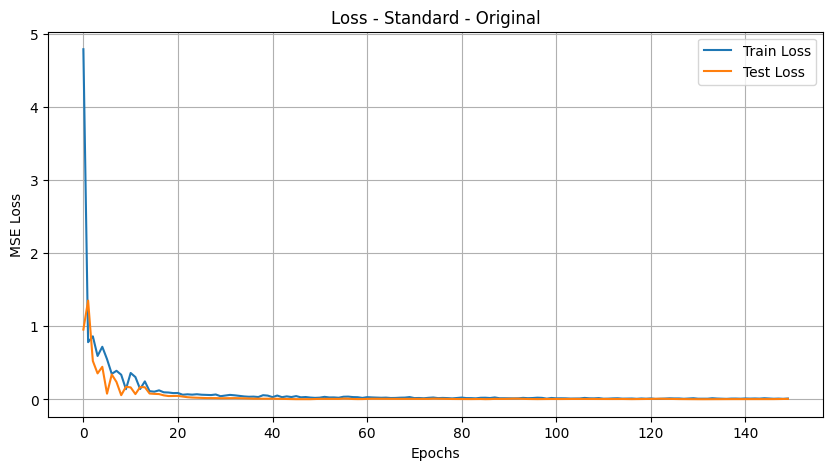


Avec augmentation:
Epoch 20/150 - Train Loss: 0.0371, Test Loss: 0.0148
Epoch 40/150 - Train Loss: 0.0203, Test Loss: 0.0099
Epoch 60/150 - Train Loss: 0.0149, Test Loss: 0.0086
Epoch 80/150 - Train Loss: 0.0127, Test Loss: 0.0049
Epoch 100/150 - Train Loss: 0.0101, Test Loss: 0.0069
Epoch 120/150 - Train Loss: 0.0078, Test Loss: 0.0035
Epoch 140/150 - Train Loss: 0.0060, Test Loss: 0.0044


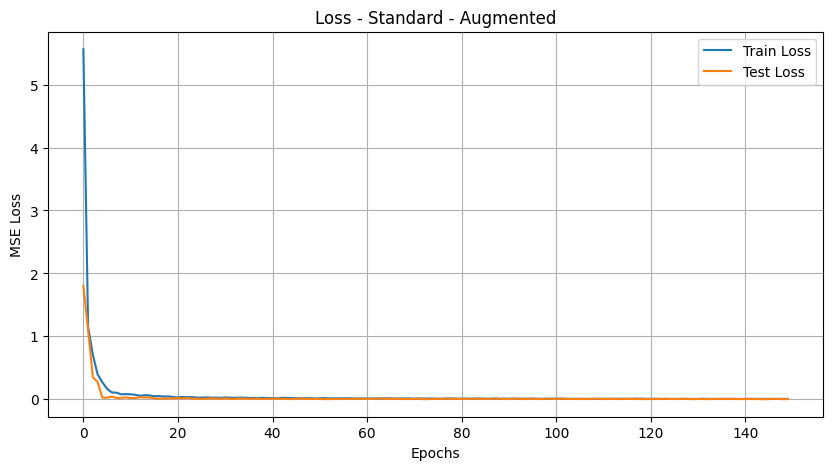


=== Traitement du dataset Maxwell-Garnett ===

Sans augmentation:
Epoch 20/150 - Train Loss: 0.0094, Test Loss: 0.0057
Epoch 40/150 - Train Loss: 0.0068, Test Loss: 0.0058
Epoch 60/150 - Train Loss: 0.0060, Test Loss: 0.0037
Epoch 80/150 - Train Loss: 0.0045, Test Loss: 0.0038
Epoch 100/150 - Train Loss: 0.0046, Test Loss: 0.0032
Epoch 120/150 - Train Loss: 0.0037, Test Loss: 0.0022
Epoch 140/150 - Train Loss: 0.0040, Test Loss: 0.0037


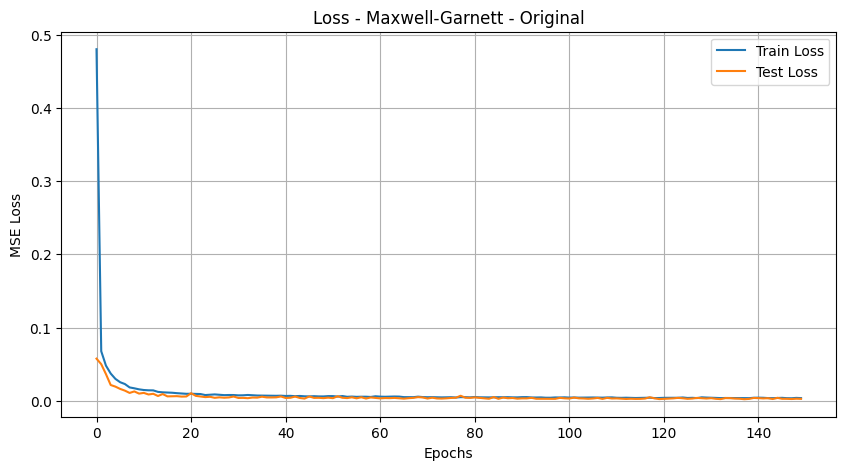


Avec augmentation:
Epoch 20/150 - Train Loss: 0.0049, Test Loss: 0.0030
Epoch 40/150 - Train Loss: 0.0040, Test Loss: 0.0023
Epoch 60/150 - Train Loss: 0.0031, Test Loss: 0.0019
Epoch 80/150 - Train Loss: 0.0027, Test Loss: 0.0018
Epoch 100/150 - Train Loss: 0.0025, Test Loss: 0.0015
Epoch 120/150 - Train Loss: 0.0024, Test Loss: 0.0020
Epoch 140/150 - Train Loss: 0.0022, Test Loss: 0.0018


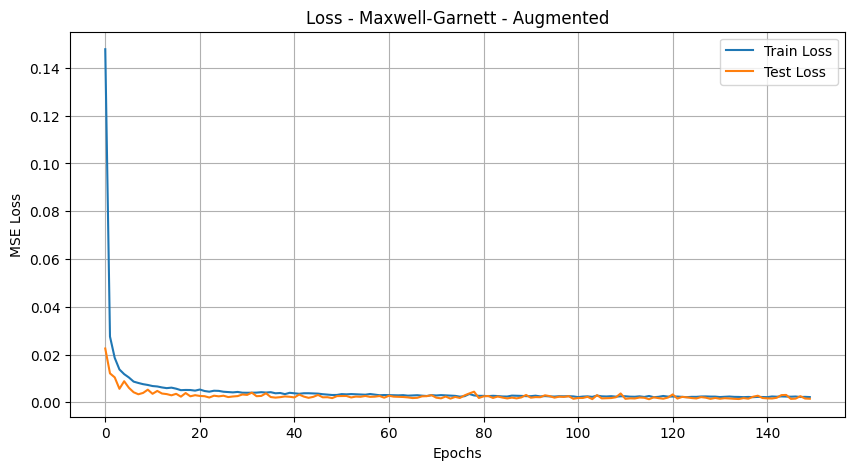


=== Traitement du dataset Lorentz ===

Sans augmentation:
Epoch 20/150 - Train Loss: 0.0186, Test Loss: 0.0157
Epoch 40/150 - Train Loss: 0.0149, Test Loss: 0.0094
Epoch 60/150 - Train Loss: 0.0124, Test Loss: 0.0093
Epoch 80/150 - Train Loss: 0.0116, Test Loss: 0.0070
Epoch 100/150 - Train Loss: 0.0099, Test Loss: 0.0059
Epoch 120/150 - Train Loss: 0.0101, Test Loss: 0.0068
Epoch 140/150 - Train Loss: 0.0092, Test Loss: 0.0056


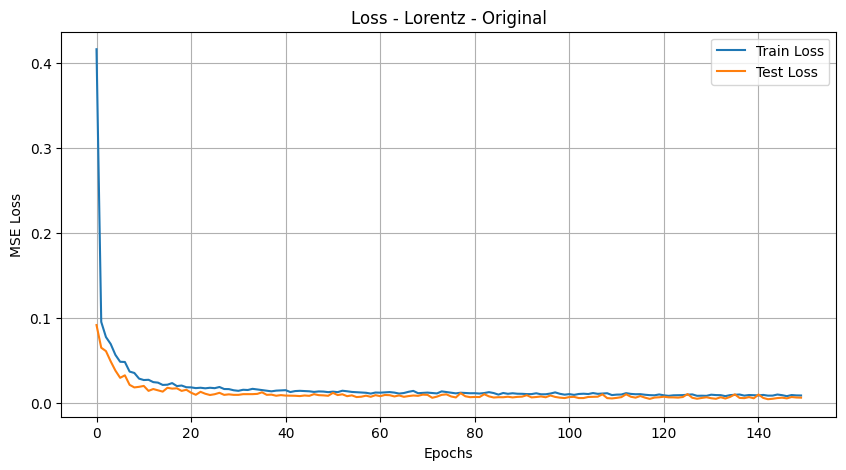


Avec augmentation:
Epoch 20/150 - Train Loss: 0.0115, Test Loss: 0.0116
Epoch 40/150 - Train Loss: 0.0094, Test Loss: 0.0052
Epoch 60/150 - Train Loss: 0.0074, Test Loss: 0.0054
Epoch 80/150 - Train Loss: 0.0060, Test Loss: 0.0042
Epoch 100/150 - Train Loss: 0.0061, Test Loss: 0.0040
Epoch 120/150 - Train Loss: 0.0056, Test Loss: 0.0040
Epoch 140/150 - Train Loss: 0.0050, Test Loss: 0.0036


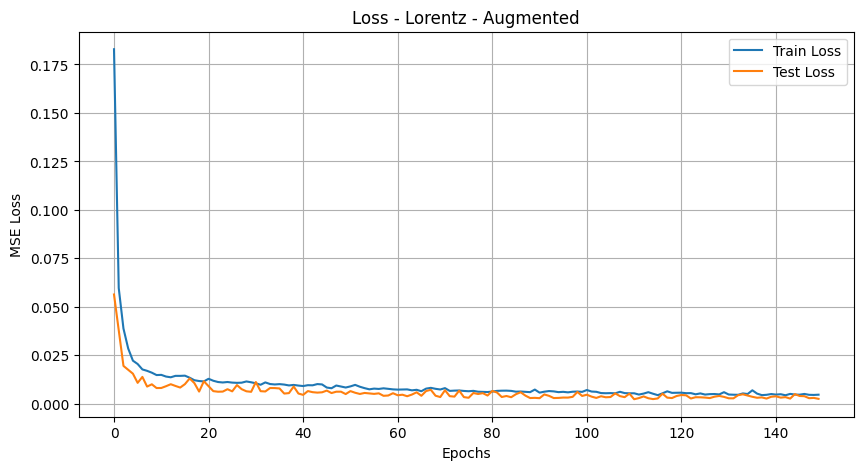


=== Analyse comparative ===

Dataset: Standard - Sans augmentation
  thickness:
    MAE: 42.2978, RMSE: 50.3197, R2: 0.9275

Dataset: Standard - Avec augmentation
  thickness:
    MAE: 32.3095, RMSE: 38.4995, R2: 0.9517

Dataset: Maxwell-Garnett - Sans augmentation
  vfraction:
    MAE: 0.0080, RMSE: 0.0154, R2: 0.9690
  thickness:
    MAE: 19.7468, RMSE: 28.1229, R2: 0.9764

Dataset: Maxwell-Garnett - Avec augmentation
  vfraction:
    MAE: 0.0081, RMSE: 0.0145, R2: 0.9710
  thickness:
    MAE: 12.4588, RMSE: 15.1293, R2: 0.9928

Dataset: Lorentz - Sans augmentation
  thickness:
    MAE: 19.5619, RMSE: 24.5077, R2: 0.9809
  lambda0:
    MAE: 1.5947, RMSE: 2.6995, R2: 0.9303
  gamma:
    MAE: 1.2707, RMSE: 2.2204, R2: 0.9316
  amplitude:
    MAE: 0.0049, RMSE: 0.0079, R2: 0.9151

Dataset: Lorentz - Avec augmentation
  thickness:
    MAE: 12.1120, RMSE: 15.3760, R2: 0.9922
  lambda0:
    MAE: 1.0716, RMSE: 1.7691, R2: 0.9699
  gamma:
    MAE: 0.8599, RMSE: 1.4594, R2: 0.9702
  amplitud

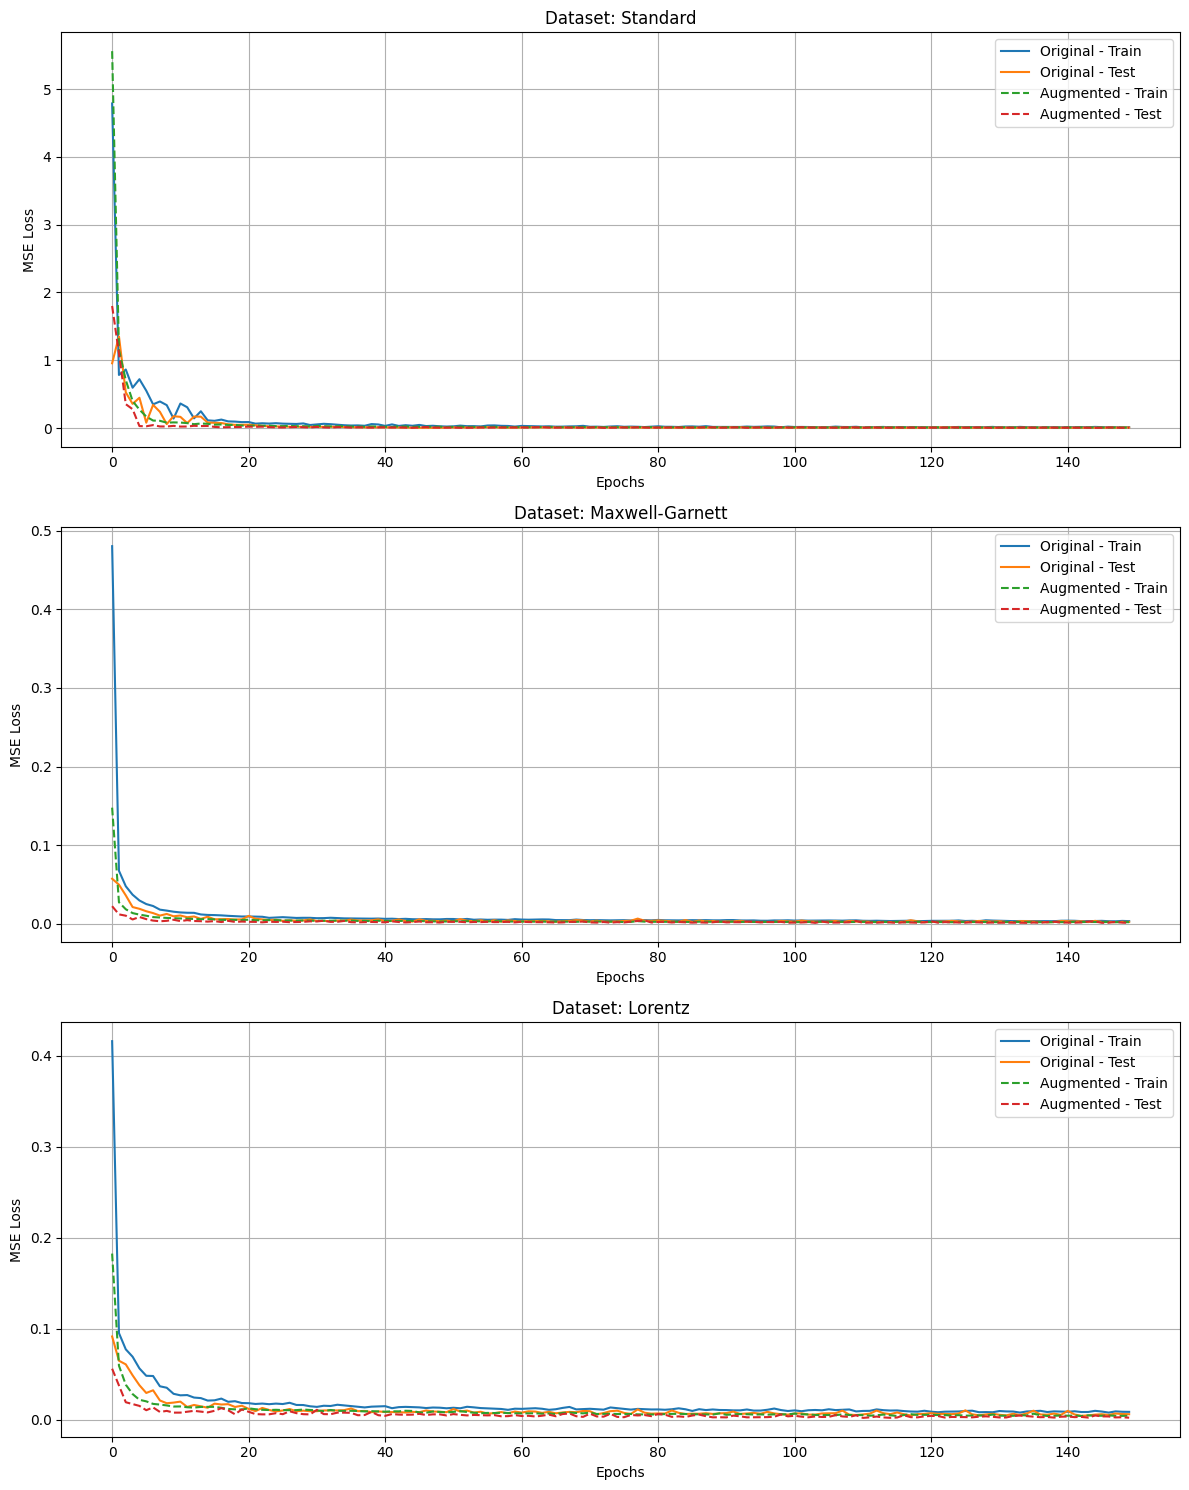


Récapitulatif des métriques:
                                 MAE                   R2            \
Augmentation                      No        Yes        No       Yes   
Dataset         Parameter                                             
Lorentz         amplitude   0.004904   0.003141  0.915050  0.965625   
                gamma       1.270696   0.859874  0.931626  0.970188   
                lambda0     1.594698   1.071568  0.930263  0.969874   
                thickness  19.561888  12.112033  0.980935  0.992162   
Maxwell-Garnett thickness  19.746809  12.458755  0.976362  0.992846   
                vfraction   0.008044   0.008133  0.968991  0.970975   
Standard        thickness  42.297844  32.309505  0.927533  0.951699   

                                RMSE             
Augmentation                      No        Yes  
Dataset         Parameter                        
Lorentz         amplitude   0.007908   0.005060  
                gamma       2.220390   1.459383  
         

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Fonction pour augmenter les données par perturbation
def augment_data(X, y, noise_level=0.01, num_augmentations=3):
    """
    Augmente les données en ajoutant du bruit gaussien
    
    Args:
        X: Features (psi_delta_flatten)
        y: Labels (paramètres physiques)
        noise_level: Niveau de bruit relatif (écart-type)
        num_augmentations: Nombre de copies augmentées à créer
    
    Returns:
        X_augmented, y_augmented: Données concaténées avec les versions augmentées
    """
    X_augmented = [X]
    y_augmented = [y]
    
    for _ in range(num_augmentations):
        # Bruit sur les features (psi et delta)
        noise_X = np.random.normal(0, noise_level * np.std(X, axis=0), X.shape)
        X_augmented.append(X + noise_X)
        
        # Bruit sur les labels (paramètres physiques)
        noise_y = np.random.normal(0, noise_level * np.std(y, axis=0), y.shape)
        y_augmented.append(y + noise_y)
    
    return np.concatenate(X_augmented), np.concatenate(y_augmented)

# Fonction pour préparer les données avec ou sans augmentation
def prepare_data_with_augmentation(grouped_df, augment=False):
    """
    Prépare les données avec option d'augmentation
    
    Args:
        grouped_df: DataFrame groupé
        augment: Booléen pour activer l'augmentation
    
    Returns:
        Dictionnaire contenant les données préparées
    """
    # Extraire features et labels
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    y = grouped_df.drop(columns=['psi_delta_flatten']).values
    label_names = grouped_df.drop(columns=['psi_delta_flatten']).columns.tolist()
    
    # Appliquer l'augmentation si demandé
    if augment:
        X, y = augment_data(X, y, noise_level=0.02, num_augmentations=2)
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Normalisation MinMax
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)
    
    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    
    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'label_names': label_names
    }

# Fonction pour entraîner et évaluer un modèle
def train_and_evaluate(model, data_dict, dataset_name, augmentation_status, epochs=100, batch_size=32):
    """
    Entraîne et évalue un modèle sur un jeu de données
    
    Args:
        model: Modèle PyTorch
        data_dict: Dictionnaire contenant les données
        dataset_name: Nom du dataset (pour affichage)
        augmentation_status: Statut d'augmentation (pour affichage)
        epochs: Nombre d'epochs
        batch_size: Taille des batches
    
    Returns:
        Dictionnaire avec les résultats et métriques
    """
    # Création des DataLoaders
    train_dataset = TensorDataset(data_dict['X_train'], data_dict['y_train'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Optimiseur et fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Entraînement
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Évaluation sur le test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(data_dict['X_test'])
            test_loss = criterion(test_outputs, data_dict['y_test']).item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        test_losses.append(test_loss)
        
        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    
    # Calcul des métriques finales
    with torch.no_grad():
        y_pred = model(data_dict['X_test'])
        y_pred_orig = data_dict['scaler_y'].inverse_transform(y_pred.numpy())
        y_test_orig = data_dict['scaler_y'].inverse_transform(data_dict['y_test'].numpy())
        
        # Calcul des métriques pour chaque paramètre
        metrics = {}
        for i, param in enumerate(data_dict['label_names']):
            mae = mean_absolute_error(y_test_orig[:, i], y_pred_orig[:, i])
            rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], y_pred_orig[:, i]))
            r2 = r2_score(y_test_orig[:, i], y_pred_orig[:, i])
            
            metrics[param] = {
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            }
    
    # Affichage des courbes
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Loss - {dataset_name} - {"Augmented" if augmentation_status else "Original"}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'metrics': metrics,
        'dataset_name': dataset_name,
        'augmentation_status': augmentation_status
    }

# Configuration des expériences
datasets = {
    'Standard': grouped_standard,
    'Maxwell-Garnett': grouped_maxwell,
    'Lorentz': grouped_lorentz
}

results = []

# Boucle sur les datasets et les conditions (avec/sans augmentation)
for name, df in datasets.items():
    print(f"\n=== Traitement du dataset {name} ===")
    
    # Sans augmentation
    print("\nSans augmentation:")
    data_dict = prepare_data_with_augmentation(df, augment=False)
    model = FlexibleNN(
        input_dim=data_dict['X_train'].shape[1],
        output_dim=data_dict['y_train'].shape[1],
        hidden_dims=[256, 256, 128],
        activation='leaky_relu',
        dropout_rate=0.1
    )
    res = train_and_evaluate(model, data_dict, name, False, epochs=150)
    results.append(res)
    
    # Avec augmentation
    print("\nAvec augmentation:")
    data_dict_aug = prepare_data_with_augmentation(df, augment=True)
    model_aug = FlexibleNN(
        input_dim=data_dict_aug['X_train'].shape[1],
        output_dim=data_dict_aug['y_train'].shape[1],
        hidden_dims=[256, 256, 128],
        activation='leaky_relu',
        dropout_rate=0.1
    )
    res_aug = train_and_evaluate(model_aug, data_dict_aug, name, True, epochs=150)
    results.append(res_aug)

# Analyse comparative des résultats
print("\n=== Analyse comparative ===")
for res in results:
    print(f"\nDataset: {res['dataset_name']} - {'Avec' if res['augmentation_status'] else 'Sans'} augmentation")
    for param, metrics in res['metrics'].items():
        print(f"  {param}:")
        print(f"    MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")

# Visualisation comparative
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
for i, dataset_name in enumerate(datasets.keys()):
    # Récupérer les résultats pour ce dataset
    res_orig = [r for r in results if r['dataset_name'] == dataset_name and not r['augmentation_status']][0]
    res_aug = [r for r in results if r['dataset_name'] == dataset_name and r['augmentation_status']][0]
    
    # Tracer les courbes de loss
    ax = axes[i]
    ax.plot(res_orig['train_losses'], label='Original - Train')
    ax.plot(res_orig['test_losses'], label='Original - Test')
    ax.plot(res_aug['train_losses'], '--', label='Augmented - Train')
    ax.plot(res_aug['test_losses'], '--', label='Augmented - Test')
    ax.set_title(f'Dataset: {dataset_name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

# Tableau récapitulatif des métriques
summary = []
for res in results:
    for param, metrics in res['metrics'].items():
        summary.append({
            'Dataset': res['dataset_name'],
            'Augmentation': 'Yes' if res['augmentation_status'] else 'No',
            'Parameter': param,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R2': metrics['R2']
        })

summary_df = pd.DataFrame(summary)
print("\nRécapitulatif des métriques:")
print(summary_df.pivot_table(index=['Dataset', 'Parameter'], columns='Augmentation', values=['MAE', 'RMSE', 'R2']))